In [25]:
#!/usr/bin/env python3

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt


In [26]:
image_size = (128, 128)
batch_size = 16

#data = tf.data.Dataset.list_files("/home/jovyan/Project/tobackus/michelangelo/cropped/*.jpg")

data = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/jovyan/Project/tobackus/michelangelo/cropped/",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    labels=None,
)

Found 154 files belonging to 1 classes.


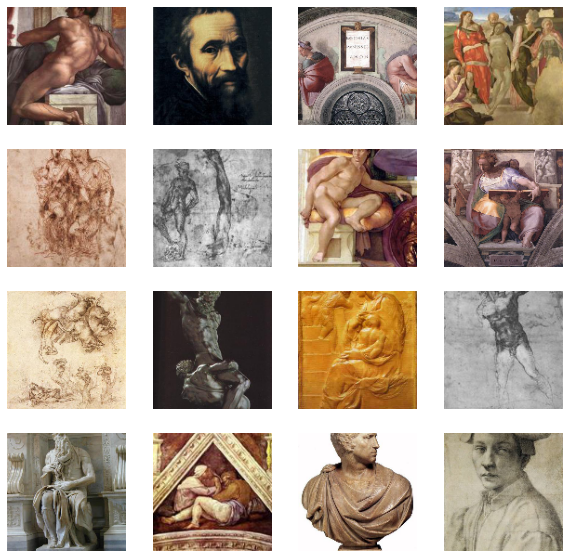

In [27]:
plt.figure(figsize=(10, 10))
for images in data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(int(labels[i]))
        plt.axis("off")
        

In [28]:
real_images = (np.vstack([i.numpy() for i in data.take(1)]))/255


In [29]:
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)
num_classes = 1
latent_dim = 128

In [30]:
#transform dataset into usable tensors

In [31]:
# Generator

noise = keras.layers.Input(shape=(latent_dim,))
#label = keras.layers.Input(shape=(1,), dtype='int32')
#label_embedding = keras.layers.Flatten()(keras.layers.Embedding(num_classes, latent_dim)(label))
#generator_input = keras.layers.Multiply()([noise, label_embedding])
generator_hidden = keras.layers.Dense(128 * 32 * 32, activation='gelu')(noise)
generator_hidden = keras.layers.Reshape((32, 32, 128))(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
generator_hidden = keras.layers.Conv2DTranspose(64, kernel_size=2, strides=2,
                                                activation='gelu')(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
generator_hidden = keras.layers.Conv2DTranspose(32, kernel_size=2, strides=2,
                                                activation='gelu')(generator_hidden)
generator_hidden = keras.layers.BatchNormalization(momentum=0.8)(generator_hidden)
g_image = keras.layers.Conv2DTranspose(channels, kernel_size=3,
                                       padding='same', activation='tanh')(generator_hidden)
generator = keras.Model(noise, g_image)
generator.compile(loss=keras.losses.BinaryCrossentropy(),
                  optimizer=keras.optimizers.Adam(0.0001,0.9))
#keras.utils.plot_model(generator,
#                       show_shapes=True,expand_nested=True)

In [32]:
#Transformer Block

class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                   key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="gelu"),
             keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [33]:
class PositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-2] 
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

In [34]:
patch_size = 8
embed_dim = 256
num_heads = 12
ff_dim = 1024
stack = 12

In [35]:
x = keras.layers.Input(shape=img_shape)
y = x
    
y = keras.layers.Conv2D(embed_dim,
                            kernel_size=(patch_size),
                            strides=(patch_size,patch_size))(y)
y = keras.layers.Reshape((-1,embed_dim))(y)
    
c = keras.layers.Lambda(lambda x: tf.tile(tf.constant([[[0.0]]]),
                                             (tf.shape(x)[0],1,embed_dim)))(x)
y = keras.layers.Concatenate(axis=1)([c,y])
 
y = PositionEmbedding(y.shape[1],embed_dim)(y)
    
for _ in range(stack):
    y = TransformerBlock(embed_dim,num_heads,ff_dim)(y)
    
y = keras.layers.Lambda(lambda x: x[:,0,:])(y)
    
y = keras.layers.Dense(ff_dim)(y)
y = keras.layers.LayerNormalization()(y)
y = keras.layers.Activation(activation=keras.activations.gelu)(y)
    
#y = keras.layers.Dense(len(np.unique(data)))(y)

valid = keras.layers.Dense(1, activation='sigmoid')(y)
#target_label = keras.layers.Dense(num_classes+1,
#                                  activation='softmax')(y)

discriminator = keras.Model(x, valid)
discriminator.compile(loss=[keras.losses.BinaryCrossentropy(),
                            keras.losses.SparseCategoricalCrossentropy()],
                      optimizer=keras.optimizers.Adam(0.00002,0.5),
                      metrics=['accuracy'])
#keras.utils.plot_model(discriminator,
#                       show_shapes=True,expand_nested=True)

In [36]:
# Combined model

discriminator.trainable = False
valid = discriminator(g_image)
combined = keras.Model(noise,valid)
combined.compile(loss=[keras.losses.BinaryCrossentropy(),
                       keras.losses.SparseCategoricalCrossentropy()],
                 optimizer=keras.optimizers.Adam(0.0002,0.5))



In [37]:
history = [[],[],[]]
half_batch_size = int(batch_size/2)

batches = 100

In [38]:
generator.load_weights("michelangelo_transGAN_weights.h5")

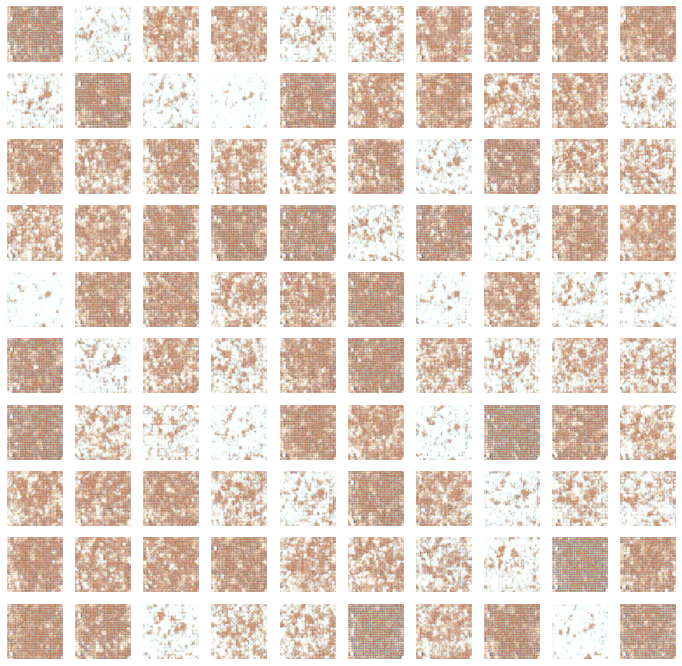

In [41]:
## Testing
r, c = 10, 10
noise = np.random.normal(0, 1, (r * c, latent_dim))
#sampled_labels = np.array([num for _ in range(r) for num in range(c)])

# Make some fakes!
generated_images = generator.predict(noise)
# Rescale images 0 - 1
generated_images = 0.5 * (generated_images + 1)

# Plot them...
fig, axs = plt.subplots(r, c)
fig.set_figwidth(12)
fig.set_figheight(12)
count = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(generated_images[count, :,:,:])
        axs[i,j].axis('off')
        count += 1
plt.show()